<a href="https://colab.research.google.com/github/Jio-Kim/ML-DL/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 농구선수의 게임 기록을 학습해서 포지션 예측 by SVM(서포트 벡터 머신)

### 최적의 SVM 파라미터 찾기
- 두개의 파라미터 사용
  
  - 비용(C) : 마진의 너비 조정 파라미터
  - 감마(gamma) : 결정 경계선의 곡률 조정하는 파라미터

- 사이킷런의 그리드 서치(gridsearch)를 사용하면 최적의 비용과 감마 알아낼 수 있음
- 그리드 서치는 개발자가 부여한 비용과 감마 후보들을 모두 조합해 최적의 비용과 감마조합 찾아냄

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('/content/basketball_stat.csv')
train, test = train_test_split(df, test_size = 0.2)

In [2]:
def svc_param_selection(X,y,nfolds):
  svm_parameters = [
      {'kernel' : ['rbf'],
       'gamma' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
       'C' : [0.01,0.1,1,10,100,1000]
       }]

# 사이킷런에서 제공하는 GridSearchCV를 사용해 최적의 파라미터를 구함
  clf = GridSearchCV(SVC(), svm_parameters, cv=10)
  clf.fit(X_train, y_train.values.ravel())
  print(clf.best_params_)

  return clf

In [7]:
# 3점슛과 블로킹 횟수를 학습 데이터로 사용
X_train = train[['3P','BLK']]

# 농구선수 포지션을 예측값으로 선정
y_train = train[['Pos']]

# 최적의 파라미터로 학습된 모델을 clf로 저장
clf = svc_param_selection(X_train, y_train.values.ravel(), 10)

{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}


### 결정 경계선 시각화

In [8]:
# 시각화할 비용 후보들 저장
C_candidates = []
C_candidates.append(clf.best_params_['C']*0.01)
C_candidates.append(clf.best_params_['C'])
C_candidates.append(clf.best_params_['C']*100)

In [32]:
C_candidates

[0.001, 0.1, 10.0]

In [11]:
# 시각화할 감마 후보들 저장
gamma_candidates = []
gamma_candidates.append(clf.best_params_['gamma']*0.01)
gamma_candidates.append(clf.best_params_['gamma'])
gamma_candidates.append(clf.best_params_['gamma']*100)

In [28]:
# 3점슛과 블로킹 횟수로 학습
X = train[['3P','BLK']]
# 농구선수 포지션을 학습 모델의 분류값으로 사용
Y = train['Pos'].tolist()

In [29]:
# 시각화를 위해 센터(C)와 슈팅가드(SG)를 숫자로 표현
position = []
for gt in Y:
  if gt == 'C':
    position.append(0)
  else:
    position.append(1)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packa

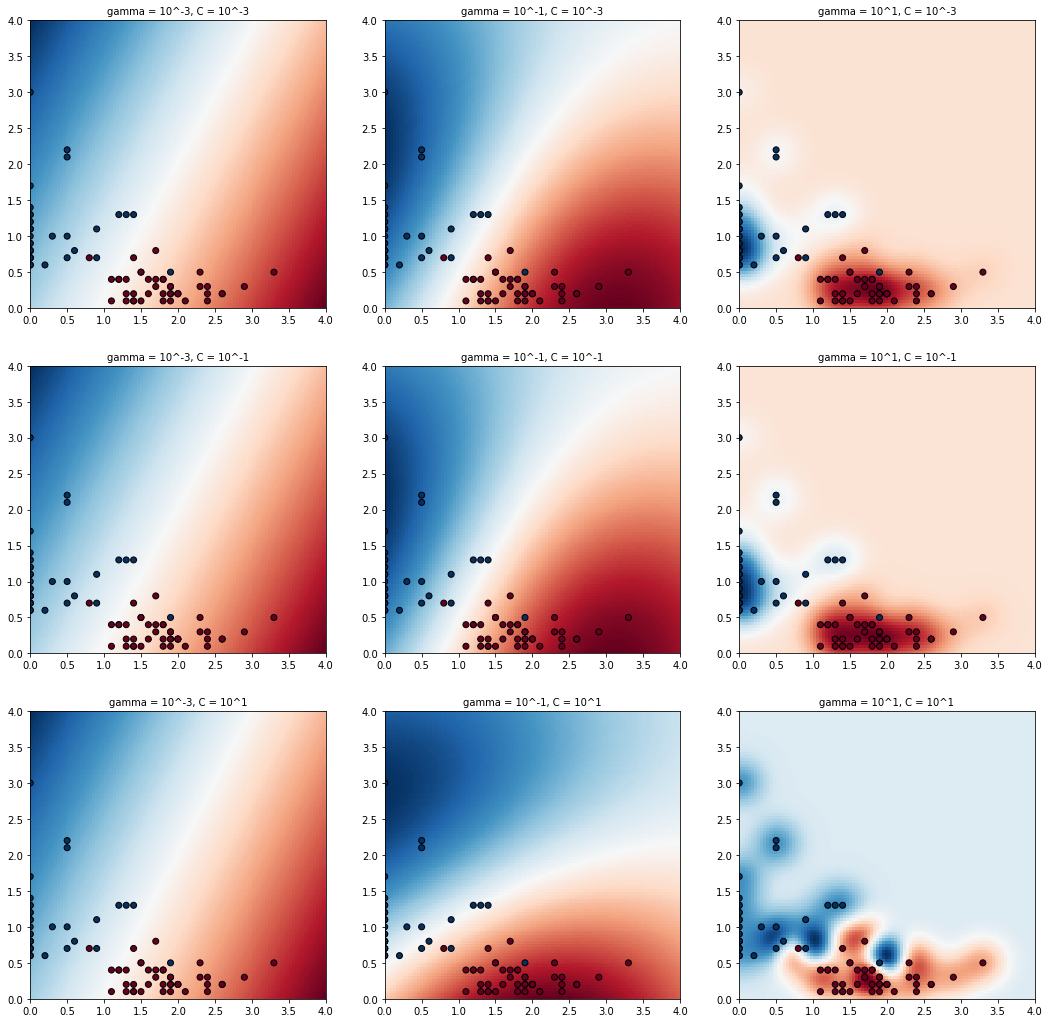

In [31]:
classifiers = []

# 파라미터 후보들을 조합해 학습된 모델들 저장
for C in C_candidates:
  for gamma in gamma_candidates:
    clf = SVC(C = C, gamma = gamma)
    clf.fit(X,Y)
    classifiers.append((C, gamma, clf))

# 각 모델 시각화
plt.figure(figsize = (18,18))
xx,yy = np.meshgrid(np.linspace(0,4,100), np.linspace(0,4,100))

for (k, (C, gamma, clf)) in enumerate(classifiers):
  Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)

  plt.subplot(len(C_candidates), len(gamma_candidates), k+1)
  plt.title("gamma = 10^%d, C = 10^%d" % (np.log10(gamma), np.log10(C)), size = 'medium')

  plt.pcolormesh(xx,yy,-Z, cmap = plt.cm.RdBu)
  plt.scatter(X['3P'], X['BLK'], c = position, cmap = plt.cm.RdBu_r, edgecolors = 'k')

- 차트 결과를 좌에서 우로 비교해 보면 감마의 크기에 따른 결정 경계의 곡률 변환을 눈으로 확인 가능
- 차트 결과를 위에서 아래로 비교하면 C의 크기에 따른 결정 경계선의 위치 변환 눈으로 확인 가능

### 모델 테스트

- gridsearch를 통해 얻은 C와 감마를 사용해 학습된 모델 테스트

In [34]:
X_test = test[['3P','BLK']]
y_test = test['Pos']

# 최적의 파라미터로 학습된 모델로 테스트 진행
y_true, y_pred = y_test, clf.predict(X_test)

print(classification_report(y_true, y_pred))
print()
print('accuracy : ' + str(accuracy_score(y_true, y_pred)))

              precision    recall  f1-score   support

           C       1.00      0.91      0.95        11
          SG       0.90      1.00      0.95         9

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20


accuracy : 0.95


In [36]:
# 실제값과 예측된 값 직접 비교하기
comparison = pd.DataFrame({'prediction' : y_pred,
                           'ground_truth' : y_true.values.ravel()})
comparison

,prediction,ground_truth
0,C,C
1,SG,SG
2,C,C
3,SG,C
4,SG,SG
5,SG,SG
6,SG,SG
7,C,C
8,SG,SG
9,SG,SG
